In [1]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.decomposition import PCA
import pandas as pd

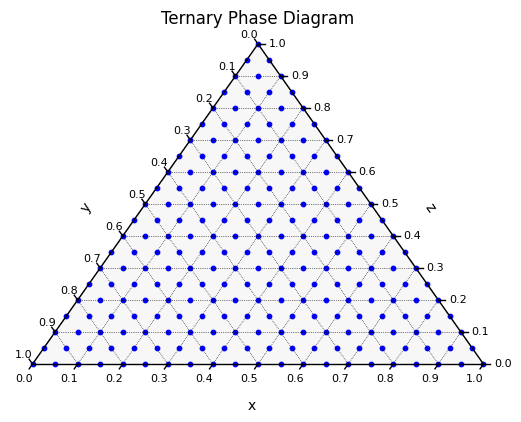

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

def generate_ternary_combinations(step=0.01):
    compositions = np.arange(0, 1 + step, step)
    ternary_combinations = []

    for x in compositions:
        for y in compositions:
            z = 1 - x - y
            if -1e-7 <= z <= 1:
                ternary_combinations.append([x, y, z])
    
    return ternary_combinations

def plot_ternary_diagram(ternary_combinations):
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="black")

    points = np.array(ternary_combinations)
    tax.scatter(points, marker='o', color='blue', s=10)

    tax.set_title("Ternary Phase Diagram")
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
    tax.get_axes().axis('off')
    tax.bottom_axis_label("x", offset=0.05)
    tax.left_axis_label("y", offset=0.14)
    tax.right_axis_label("z", offset=0.14)
    tax.clear_matplotlib_ticks()
    tax.show()


step_size = 0.05
ternary_combinations = generate_ternary_combinations(step_size)
plot_ternary_diagram(ternary_combinations)

In [86]:
c_a, c_b, c_c = [], [], []
for x, y, z in ternary_combinations:
    c_a.append(x)
    c_b.append(y)
    c_c.append(z)

c_a = np.array(c_a)
c_b = np.array(c_b)
c_c = np.array(c_c)

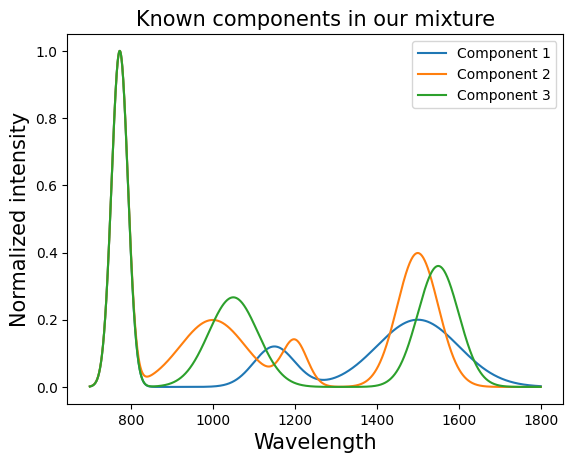

In [87]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

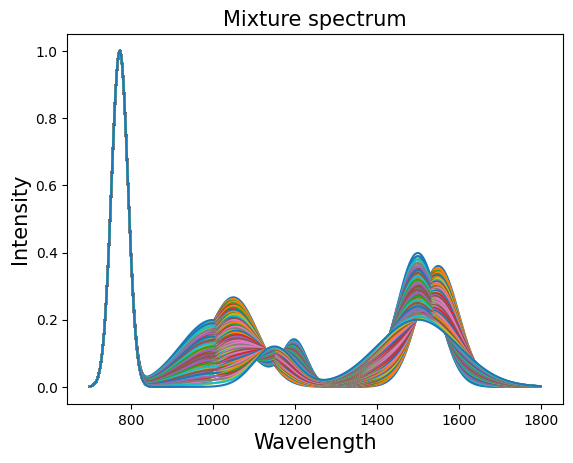

In [88]:
# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()


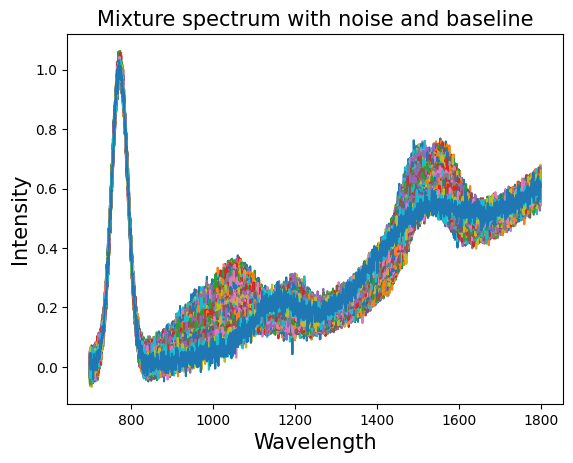

In [89]:
# Let's add some noise for a bit of realism:

# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)

# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly


plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum with noise and baseline', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [90]:
# Estimation of the baseline:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.0009 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# Reasoning baseline + noise

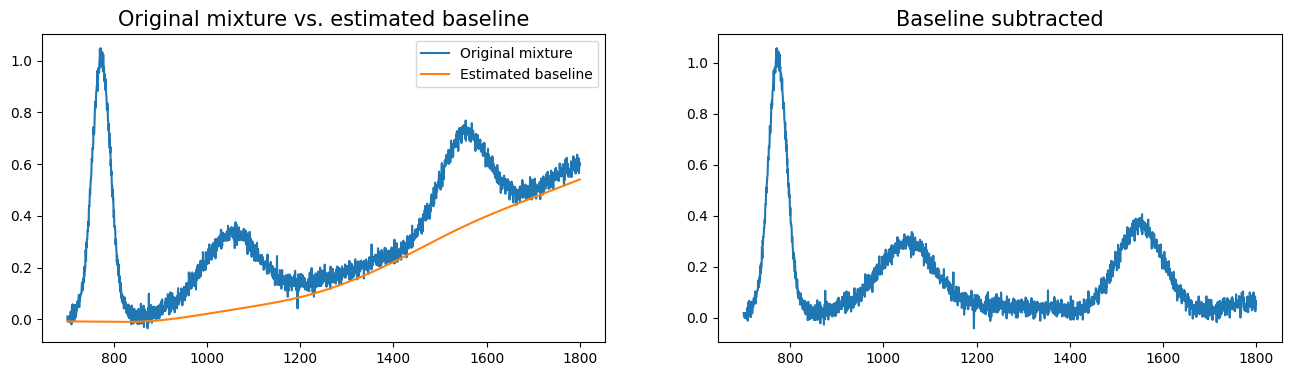

In [91]:
# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, mixture[0].T, label = 'Original mixture')
ax1.plot(x_range, estimated_baselined[:,0], label = 'Estimated baseline')
ax1.set_title('Original mixture vs. estimated baseline', fontsize = 15)

# We compared the original mix spectrum and the estimated baseline:

ax2.plot(x_range, baselined_spectrum[:,0], label = 'Baseline subtracted')
ax2.set_title('Baseline subtracted', fontsize = 15)

ax1.legend()
plt.show()

In [92]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/

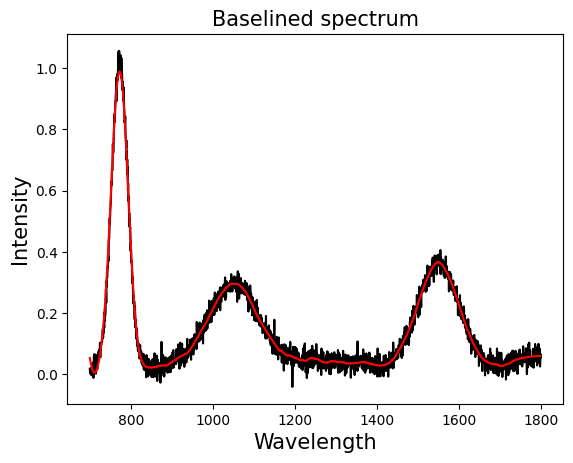

In [93]:
# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum[:,0], color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum[0], color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [94]:
cov = np.cov(smoothed_spectrum.T)
cov.shape

(2000, 2000)

In [95]:
pca = PCA().fit(cov)

In [96]:
pca.explained_variance_ratio_

array([6.78982667e-01, 3.20903576e-01, 5.83657010e-05, ...,
       4.17403386e-33, 1.82459463e-33, 7.22300014e-34])

In [97]:
np.cumsum(pca.explained_variance_ratio_)

array([0.67898267, 0.99988624, 0.99994461, ..., 1.        , 1.        ,
       1.        ])

In [98]:
pca = PCA(n_components=2)
pca.fit(cov)

PCA(n_components=2)

In [99]:
pc_spectrum = pca.transform(smoothed_spectrum)

In [100]:
pc_spectrum.shape

(231, 2)

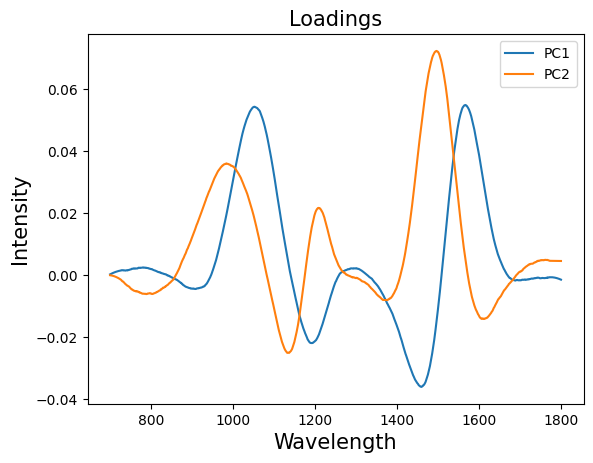

In [101]:
# Loadings
plt.plot(x_range, pca.components_[0], label = 'PC1')
plt.plot(x_range, pca.components_[1], label = 'PC2')
plt.title('Loadings', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.legend()

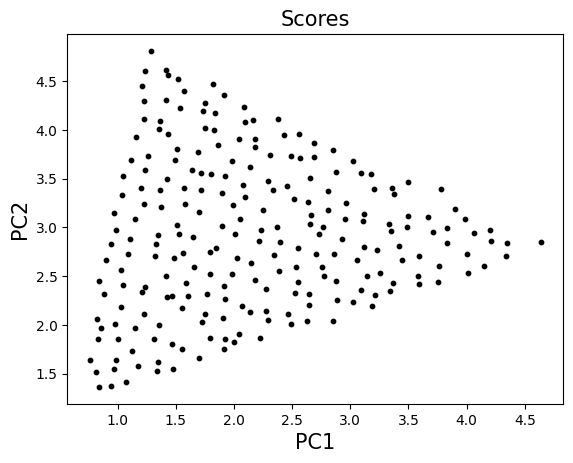

In [130]:
plt.scatter(pc_spectrum[:,0], pc_spectrum[:,1], c='black', s=10)

plt.title('Scores', fontsize = 15)
plt.xlabel('PC1', fontsize = 15)
plt.ylabel('PC2',  fontsize = 15)
plt.show()

In [103]:
print(len(np.where(pc_spectrum[:, 0] < 0.8)[0]))

1


In [104]:
concentrations = np.array([c_a, c_b, c_c]).T
print(np.argmin(pc_spectrum[:,1]))
print(np.argmax(pc_spectrum[:,1]))
print(np.argmax(pc_spectrum[:,0]))
print(concentrations[np.argmin(pc_spectrum[:,1])])
print(concentrations[np.argmax(pc_spectrum[:,1])])
print(concentrations[np.argmax(pc_spectrum[:,0])])
print(len(np.where(((concentrations[:,0] > 0.5) | (concentrations[:,1] > 0.5)) & (concentrations[:, 2] < 0.05))[0]))


230
20
0
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
37


In [105]:
from sklearn.linear_model import LinearRegression
X = pc_spectrum
# Splitting the data into train, validation and test sets:
X_train = pc_spectrum[:150]
X_val = pc_spectrum[150:175]
X_test = pc_spectrum[175:]

concentrations = np.array([c_a, c_b, c_c]).T
y_train = concentrations[:150]
y_val = concentrations[150:175]
y_test = concentrations[175:]

In [106]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
y_pred_test = reg.predict(X_test)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_test = np.clip(y_pred_test, 0, None)

In [107]:
# Evaluation metrics:
# RMSE:
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
rmse_val = np.sqrt(np.mean((y_pred_val - y_val)**2))
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))

# MAE:
mae_train = np.mean(np.abs(y_pred_train - y_train))
mae_val = np.mean(np.abs(y_pred_val - y_val))
mae_test = np.mean(np.abs(y_pred_test - y_test))

df = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test], 'MAE': [mae_train, mae_val, mae_test]}, index = ['Train', 'Validation', 'Test'])
df.round(3)

,RMSE,MAE
Train,0.012,0.010
Validation,0.014,0.011
Test,0.024,0.019


In [108]:
# Print some results:
y_test = np.round(y_test, 3)
y_pred_test = np.round(y_pred_test, 3)

df = pd.DataFrame({'Real concentration A': y_test[:,0], 'Predicted concentration A': y_pred_test[:,0], 'Real concentration B': y_test[:,1], 'Predicted concentration B': y_pred_test[:,1], 'Real concentration C': y_test[:,2], 'Predicted concentration C': y_pred_test[:,2]})
# Multi level column names:
df.columns = pd.MultiIndex.from_product([['Concentration A', 'Concentration B', 'Concentration C'], ['Real', 'Predicted']])
df

Concentration A           Concentration B           Concentration C  \
              Real Predicted            Real Predicted            Real   
0             0.50     0.494            0.50     0.501            0.00   
1             0.55     0.505            0.00     0.029            0.45   
2             0.55     0.524            0.05     0.066            0.40   
3             0.55     0.528            0.10     0.108            0.35   
4             0.55     0.528            0.15     0.176            0.30   
5             0.55     0.538            0.20     0.211            0.25   
6             0.55     0.538            0.25     0.266            0.20   
7             0.55     0.546            0.30     0.308            0.15   
8             0.55     0.510            0.35     0.381            0.10   
9             0.55     0.539            0.40     0.417            0.05   
10            0.55     0.536            0.45     0.465           -0.00   
11            0.60     0.581            0.00     0.019            0.40   
12            0.60     0.599            0.05     0.054            0.35   
13            0.60     0.581            0.10     0.119            0.30   
14            0.60     0.592            0.15     0.151            0.25   
15            0.60     0.569            0.20     0.224            0.20   
16            0.60     0.590            0.25     0.241            0.15   
17            0.60     0.620            0.30     0.284            0.10   
18            0.60     0.591            0.35     0.375            0.05   
19            0.60     0.586            0.40     0.420           -0.00   
20            0.65     0.627            0.00     0.033            0.35   
21            0.65     0.631            0.05     0.053            0.30   
22            0.65     0.616            0.10     0.130            0.25   
23            0.65     0.608            0.15     0.194            0.20   
24            0.65     0.598            0.20     0.245            0.15   
25            0.65     0.603            0.25     0.296            0.10   
26            0.65     0.628            0.30     0.326            0.05   
27            0.65     0.649            0.35     0.364           -0.00   
28            0.70     0.659            0.00     0.024            0.30   
29            0.70     0.647            0.05     0.074            0.25   
30            0.70     0.712            0.10     0.097            0.20   
31            0.70     0.683            0.15     0.166            0.15   
32            0.70     0.672            0.20     0.218            0.10   
33            0.70     0.685            0.25     0.264            0.05   
34            0.70     0.674            0.30     0.320           -0.00   
35            0.75     0.712            0.00     0.025            0.25   
36            0.75     0.713            0.05     0.069            0.20   
37            0.75     0.724            0.10     0.130            0.15   
38            0.75     0.722            0.15     0.183            0.10   
39            0.75     0.738            0.20     0.217            0.05   
40            0.75     0.748            0.25     0.253            0.00   
41            0.80     0.776            0.00     0.019            0.20   
42            0.80     0.778            0.05     0.057            0.15   
43            0.80     0.784            0.10     0.118            0.10   
44            0.80     0.771            0.15     0.169            0.05   
45            0.80     0.765            0.20     0.222           -0.00   
46            0.85     0.802            0.00     0.031            0.15   
47            0.85     0.814            0.05     0.067            0.10   
48            0.85     0.827            0.10     0.109            0.05   
49            0.85     0.798            0.15     0.191           -0.00   
50            0.90     0.871            0.00     0.029            0.10   
51            0.90     0.854            0.05     0.081            0.05   
52     